In [1]:
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

In [2]:
features_directory = '/Users/lamahasbini/Library/CloudStorage/OneDrive-AmericanUniversityofBeirut/FYP 2024-25 ECE/FYP_Fall_2024-2025/ML Implementation/RF_first_try/features'
features_df = pd.DataFrame()

for file in os.listdir(features_directory):
    if file.endswith('.csv'):
        file_path = os.path.join(features_directory, file)
        temp = pd.read_csv(file_path)
        parts = file.replace('.csv', '').split('_')
        patient_id = f"{parts[-2]}_{parts[-1]}"
        
        temp['Patient_ID'] = patient_id  
        features_df = pd.concat([features_df, temp], ignore_index=True)

print(features_df)

           Mode    Median    MaxAbs  LineLength  10thQuantile  75thQuantile  \
0      0.256090  0.257795  4.000000    3.745123      0.256178      0.258123   
1      0.256271  0.259584  0.260198    0.004233      0.256971      0.260031   
2      0.259068  0.260004  0.260528    0.002677      0.259153      0.260201   
3      0.260592  0.261212  0.261553    0.002090      0.260943      0.261330   
4      0.260543  0.261351  0.261547    0.002381      0.260657      0.261450   
...         ...       ...       ...         ...           ...           ...   
46074  0.137735  0.138617  0.139257    0.001609      0.137823      0.139119   
46075  0.137768  0.137965  0.138593    0.001052      0.137860      0.138386   
46076  0.137561  0.137830  0.138889    0.002131      0.137613      0.138564   
46077  0.137962  0.138478  0.138784    0.001489      0.138241      0.138600   
46078  0.138364  0.138666  0.139057    0.001295      0.138420      0.138899   

       NonLinearEnergy   SVD_Entropy  ShannonEntrop

In [3]:
features_df['Sleep_stage'] = features_df['Sleep_stage'].astype(str)
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('3', '2')
features_df['Sleep_stage'] = features_df['Sleep_stage'].replace('r', 'R')

In [4]:
print(features_df.head()) 
print(f"Total records combined: {len(features_df)}")

       Mode    Median    MaxAbs  LineLength  10thQuantile  75thQuantile  \
0  0.256090  0.257795  4.000000    3.745123      0.256178      0.258123   
1  0.256271  0.259584  0.260198    0.004233      0.256971      0.260031   
2  0.259068  0.260004  0.260528    0.002677      0.259153      0.260201   
3  0.260592  0.261212  0.261553    0.002090      0.260943      0.261330   
4  0.260543  0.261351  0.261547    0.002381      0.260657      0.261450   

   NonLinearEnergy   SVD_Entropy  ShannonEntropy  Average EDA per epoch  ...  \
0         0.970088 -1.442695e-10        0.210842               0.259464  ...   
1        -0.002847 -1.442695e-10        2.678204               0.262164  ...   
2        -0.000259 -1.442695e-10        3.076895               0.263591  ...   
3        -0.000548 -1.442695e-10        3.031402               0.264969  ...   
4        -0.000012 -1.442695e-10        2.815061               0.265454  ...   

            Date_E4_synced  time_since_storm_start time_since_last_s

In [5]:
features_df.isnull().sum()

Mode                        23
Median                      23
MaxAbs                      23
LineLength                  23
10thQuantile                23
75thQuantile                23
NonLinearEnergy             23
SVD_Entropy               1071
ShannonEntropy              23
Average EDA per epoch      374
EDR_count                  374
Storm_mark                   0
Sleep_stage                  0
Age                          0
Gender                       0
Date_E4_synced               0
time_since_storm_start       0
time_since_last_storm        0
ACC_mean                   459
BVP_mean                   758
HR_mean                    459
TEMP_mean                  459
Date_E4_TZ                   0
Date_E4_synced_str           0
Patient_ID                   0
dtype: int64

In [6]:
features_df = features_df.dropna()
print(f"Total records: {len(features_df)}")

Total records: 44040


In [7]:
X = features_df.drop(['Sleep_stage', 'Patient_ID', 'Date_E4_synced', 'Date_E4_TZ', 'Date_E4_synced_str'], axis=1)
print(X)

y = features_df['Sleep_stage']

           Mode    Median    MaxAbs  LineLength  10thQuantile  75thQuantile  \
0      0.256090  0.257795  4.000000    3.745123      0.256178      0.258123   
1      0.256271  0.259584  0.260198    0.004233      0.256971      0.260031   
2      0.259068  0.260004  0.260528    0.002677      0.259153      0.260201   
3      0.260592  0.261212  0.261553    0.002090      0.260943      0.261330   
4      0.260543  0.261351  0.261547    0.002381      0.260657      0.261450   
...         ...       ...       ...         ...           ...           ...   
46065  0.137638  0.137941  0.138195    0.001070      0.137677      0.138141   
46066  0.137972  0.138280  0.138386    0.001013      0.138009      0.138361   
46067  0.137700  0.138069  0.138328    0.001106      0.137738      0.138220   
46068  0.137539  0.137900  0.138212    0.001516      0.137614      0.138015   
46069  0.137605  0.138057  0.138410    0.001851      0.137698      0.138261   

       NonLinearEnergy   SVD_Entropy  ShannonEntrop

In [8]:
if "Gender" in X.columns:
    le = LabelEncoder()
    X["Gender"] = le.fit_transform(X["Gender"])  # Converts 'Female' -> 0, 'Male' -> 1

In [9]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [11]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
param_grid = {
    'C': [0.1, 1, 10],            # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['linear', 'rbf']   # Different SVM kernels
}

# Run GridSearch
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 5.4min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 5.4min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 5.4min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 5.5min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 5.5min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time= 5.5min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 7.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 7.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 7.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 7.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 7.1min
[CV] END ...................C=0.1, gamma=auto, 

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 4.7min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 4.4min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 4.8min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 4.6min
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=62.2min
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=72.5min
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=68.5min
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=65.7min
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=67.3min
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time= 3.2min
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time= 3.3min
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time= 3.3min
[CV] END ...................

KeyboardInterrupt: 

In [ ]:
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [ ]:
# Make predictions
y_pred = best_svm.predict(X_test)

# Convert predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# Evaluate performance
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))

Classification Report:
               precision    recall  f1-score   support

           1       0.22      0.03      0.06       628
           2       0.61      0.92      0.74      4935
           R       0.56      0.23      0.33      2013
           W       0.57      0.26      0.36      1351

    accuracy                           0.60      8927
   macro avg       0.49      0.36      0.37      8927
weighted avg       0.57      0.60      0.54      8927



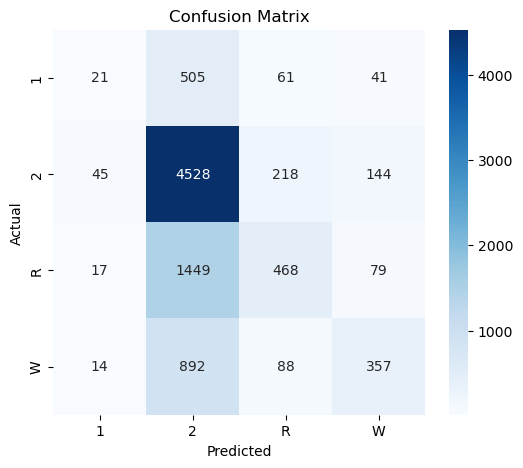

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()